<a href="https://colab.research.google.com/github/namirinz/YSC21-AI_KME/blob/master/Image_Captioning/KME_Image_captioning_bahdanau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import albumentations as A

In [2]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
!nvidia-smi -L

GPU 0: GeForce RTX 3080 (UUID: GPU-a38dd65b-bdf5-159e-8b35-dd0c4396bd53)


# Import Dataset

In [4]:
df = pd.read_csv('../Web_Scraping/dataframe_with_label.csv', dtype='str', converters={'label': eval})
df.drop('Unnamed: 0', axis=1, inplace = True)
df = df.sample(frac=1).reset_index(drop=True)
lst_iupacname = df.iupacname.to_list()

display(df.head())
print(len(df))

cid                                          iupacname  \
0   21905193.png         2-[(2,3-difluorophenyl)methoxy]acetic acid   
1   58422531.png         1-(4-hydroxyphenyl)-3-methylbut-3-en-2-one   
2  141293642.png  2-(2,3-dihydroimidazo[1,2-a]pyridin-3-yl)-2-ox...   
3       8631.png                   2-hydroxy-3,5-diiodobenzoic acid   
4      16968.png                                    hepta-1,6-diene   

                                               label  
0  [1, 16, 17, 80, 38, 16, 21, 22, 17, 27, 40, 81...  
1  [1, 34, 17, 38, 20, 17, 71, 81, 18, 39, 17, 22...  
2  [1, 16, 17, 38, 16, 21, 22, 17, 27, 618, 609, ...  
3  [1, 16, 17, 71, 17, 22, 21, 25, 17, 27, 37, 62...  
4  [1, 12, 47, 17, 34, 21, 44, 17, 27, 46, 2, 0, ...

8200


In [5]:
df.drop_duplicates('cid', inplace=True, ignore_index=True)
print(len(df))

8128


In [6]:
sequences = np.array(df.label.to_list())

label_cols = [ 'label_'+str(i) for i in range(sequences.shape[1])]

new_df = pd.DataFrame(sequences, columns = label_cols)

df = pd.concat([df, new_df], axis=1).drop('label', axis=1)

## Preprocessing Dataset

In [7]:
from nami.AI.kme_tokenize import Tokenizer
tokenizer = Tokenizer()

In [8]:
import json

def init_tokenizer(load_json = True):
    if load_json:        
        with open('tokenizer/index2word.json', 'r') as f1:
            tokenizer.index2word = json.load(f1)
            tokenizer.index2word = {int(k):v for k,v in tokenizer.index2word.items()}
        with open('tokenizer/longest_sentences.json', 'r') as f2:
            tokenizer.longest_sentences = json.load(f2)

        with open('tokenizer/num_words.json', 'r') as f3:
            tokenizer.num_words = json.load(f3)

        with open('tokenizer/word2count.json', 'r') as f4:
            tokenizer.word2count = json.load(f4)

        with open('tokenizer/word2index.json', 'r') as f5:
            tokenizer.word2index = json.load(f5)
    else:
        tokenizer.fit_on_texts(lst_iupacname[:])

In [9]:
init_tokenizer(True)
tokenizer.longest_sentences

67

## Hyperparameter

In [10]:
BATCH_SIZE = 16
units = 512
vocab_size = len(tokenizer.word2index)

IMG_SIZE = 300
IMG_SHAPE = (300, 300, 3)

max_length_train = tokenizer.longest_sentences
max_length_test = tokenizer.longest_sentences

encoding_size = 256 # Determines dimension of the encodings of images
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
len(tokenizer.word2index)

778

# Create Dataset

## Augmentation

In [12]:
transforms = A.Compose([
      A.RGBShift(p=0.2),
      A.GaussNoise(var_limit=(100, 150), p= 0.5),
      A.ShiftScaleRotate(interpolation=4, border_mode=1, p=1.0),
      #A.Blur(blur_limit= 3, p= 0.5),
      # HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
      A.Flip(p= 0.5), A.Transpose(p= 0.5),
      A.ToGray(p= 0.5),
      #A.ChannelShuffle(p= 0.5),
      #A.RandomBrightness(limit=(-0.10, 0.0), p= 0.5)
], p=0.9)

In [13]:
from ImageDataAugmentor.image_data_augmentor import ImageDataAugmentor
from efficientnet.tfkeras import preprocess_input

img_gen = ImageDataAugmentor(augment = transforms, rescale=1./255, validation_split=0.2)

img_dir = '../Web_Scraping/kme_image_dataset/batch_1'
generator = img_gen.flow_from_dataframe(
    df, img_dir, x_col='cid', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE, subset='training'
)

generator_val = img_gen.flow_from_dataframe(
    df, img_dir, x_col='cid', y_col=label_cols,
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE, subset='validation'
)

Found 6503 validated image filenames.
Found 1625 validated image filenames.


## Tf.data.Dataset

In [14]:
dataset = tf.data.Dataset.from_generator(
    lambda: generator,
    output_types = (tf.float32, tf.float32
    ),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

dataset_val = tf.data.Dataset.from_generator(
    lambda: generator_val,
    output_types = (tf.float32, tf.float32),
    output_shapes = ([None, 300, 300, 3], [None, tokenizer.longest_sentences])
).cache().prefetch(AUTOTUNE)

In [15]:
num_steps_train = generator.samples // BATCH_SIZE
num_steps_test = generator_val.samples // BATCH_SIZE

## Plot Augmentation

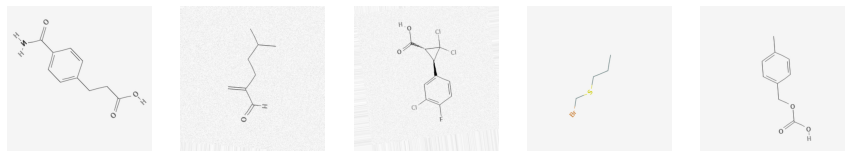

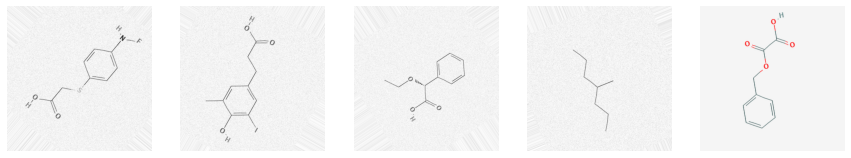

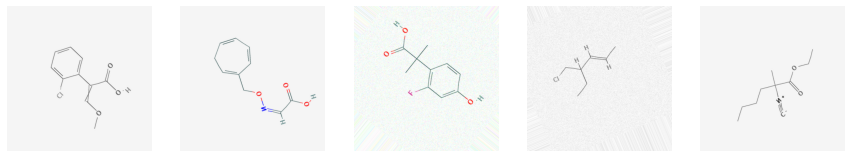

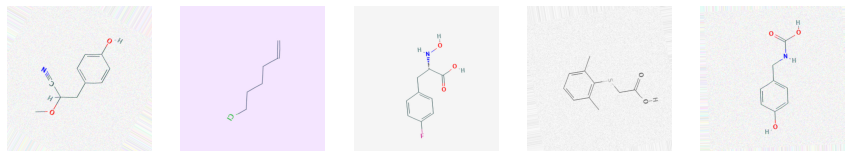

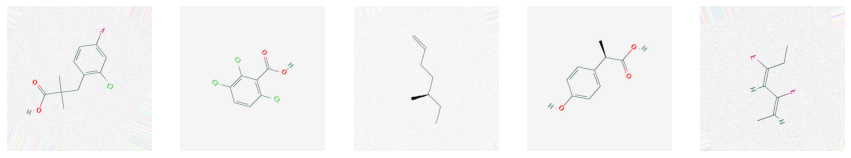

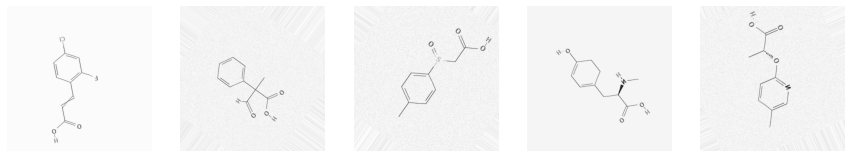

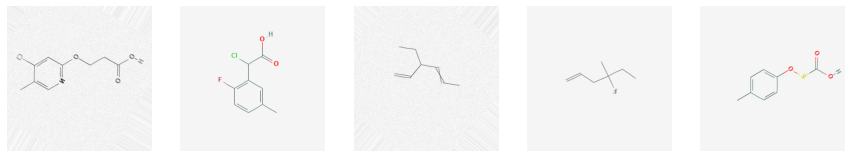

In [16]:
# Test parameter of ImageDataGenerator

for index, (img, label) in enumerate(dataset):
  plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.imshow( img[i] )
    plt.axis('off')
  plt.show()
  if index == 6:
    break

# Model Architecture

## EfficientNet-B7


In [17]:
import efficientnet.tfkeras as efn

pret_model = efn.EfficientNetB1(include_top = False, weights='noisy-student', input_shape=IMG_SHAPE)

pret_model.trainable = True

attention_features_shape = 10 * 10
features_shape = 1280

# Xception : [7, 7, 2048]
# InceptionResNetV2 : [5, 5, 1536]
# EfficientNetB0 : [7, 7, 2560]

In [18]:
# pret_model.summary()

## CNN Encoder (Encoder output of feature extraction)

In [19]:
from tensorflow.keras.models import Sequential

def create_encoder():
  x = tf.keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer")(pret_model.output)
  output = tf.keras.layers.Reshape(target_shape=(attention_features_shape, encoding_size))(x)
  return tf.keras.Model(pret_model.input, output)

In [20]:
encoder = create_encoder()

In [21]:
from tensorflow.keras.layers import BatchNormalization

for index, layer in enumerate(encoder.layers):
  if index <= 20 and not isinstance(layer, BatchNormalization):
    layer.trainable = True

In [22]:
# encoder.summary()

## Bahdanau Attention

In [23]:
from tensorflow.keras.layers import Dense, Embedding, GRU

In [24]:
def create_attention(features, hidden):
  # features(CNN_encoder output) shape == (batch_size, 100, embedding_dim)
 
  # hidden shape == (batch_size, hidden_size)
  # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
  hidden_with_time_axis = tf.expand_dims(hidden, 1)

  # attention_hidden_layer shape == (batch_size, 100, units)
  # Bahdanau's additive style
  attention_hidden_layer = tf.nn.tanh( Dense(units)(features) + Dense(units)(hidden_with_time_axis) )
  
  # score shape == (batch_size, 100, 1)
  # This gives you an unnormalized score for each image feature.
  score = tf.keras.layers.Dense(1)(attention_hidden_layer)

  # attention_weights shape == (batch_size, 100, 1)
  attention_weights = tf.nn.softmax(score, axis=1)

  # context_vector shape after sum == (batch_size, hidden_size)
  context_vector = attention_weights * features
  context_vector = tf.reduce_sum(context_vector, axis=1)

  return context_vector, attention_weights

## Create RNN Decoder

In [25]:
def create_decoder():
  features = tf.keras.layers.Input((attention_features_shape, encoding_size))
  dec_input= tf.keras.layers.Input((1))
  hidden = tf.keras.layers.Input((units))

  # context vector == (batch_size, hidden_size)
  context_vector, attention_weights = create_attention(features, hidden)
  
  # x shape after passing through embedding == (batch_size, 1, encoding_size) 
  x = Embedding(vocab_size, encoding_size)(dec_input)
  
  # x shape after concatenation == (batch_size, 1, encoding_size + hidden_size)
  x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
  
  # passing the concatenated vector to the GRU
  output, state = GRU(units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')(x)
  
  # shape == (batch_size, max_length, hidden_size)
  x = Dense(units)(output)
  
  # x shape == (batch_size * max_length, hidden_size)
  x = tf.reshape(x, (-1, x.shape[2]))

  # output shape == (batch_size * max_length, vocab)
  x = Dense(vocab_size)(x)

  return tf.keras.models.Model([features, dec_input, hidden], [x, state, attention_weights])

def reset_state(batch_size):
  return tf.zeros((batch_size, units))

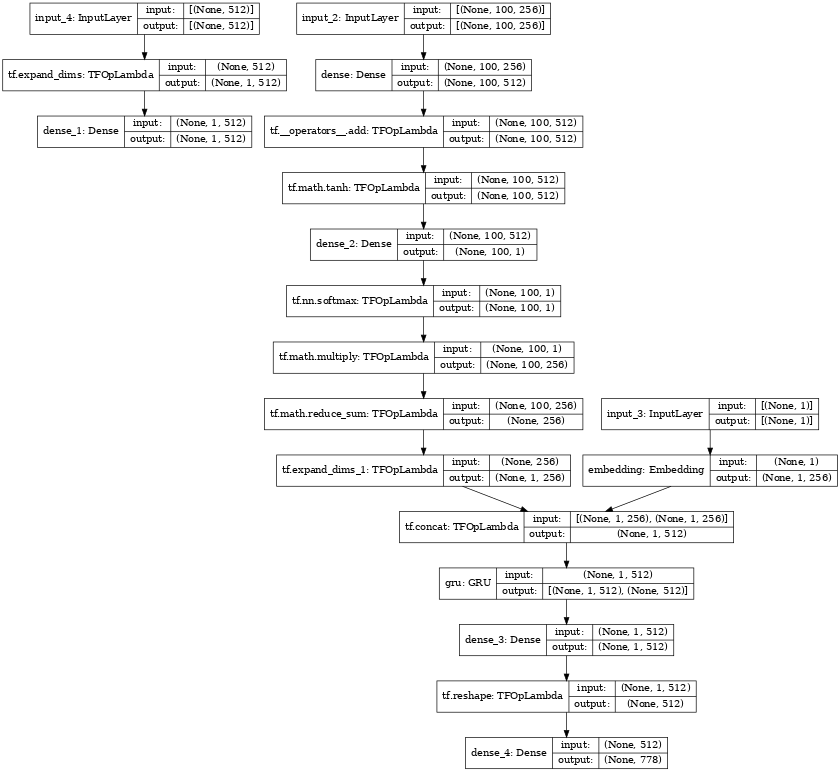

In [26]:
decoder = create_decoder()
tf.keras.utils.plot_model(decoder, show_shapes=True, dpi = 49)

# Custom Loss Function


In [27]:
def loss_fn(real, pred):
  # Word Loss

  real_onehot = tf.one_hot(tf.cast(real, tf.uint8), vocab_size)

  loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction = 'none', label_smoothing=0.2)
  mask = tf.math.logical_not(tf.math.equal(real, tokenizer.word2index['<pad>'])) # make padding element -> true(1) -> false (0)
  loss_ = loss_object(real_onehot, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

# Metrics

# Accuracy

In [28]:
train_acc = tf.keras.metrics.Accuracy(name='train_accuracy')
val_acc = tf.keras.metrics.Accuracy(name='val_accuracy')

# Bleu

In [29]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

class Bleu(tf.keras.metrics.Metric):
  def __init__(self, name='bleu', **kwargs):
    super(Bleu, self).__init__(name=name, **kwargs)
    self.score = self.add_weight(name='score', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')
    self.chencherry = SmoothingFunction()

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = y_true[y_true != tokenizer.word2index['<pad>']]
    idx = np.where(y_pred == tokenizer.word2index['<end>'])[0]

    if idx != []:
      y_pred = y_pred[:idx[0]+1]
    
    values = sentence_bleu([y_true[1:]], y_pred, smoothing_function=self.chencherry.method4)
    print(y_true)
    print(y_pred)
    print(values)

    self.count.assign_add(1)
    self.score.assign_add(values)

  def result(self):
    return self.score / self.count

  def reset_states(self):
    self.count.assign(0)
    self.score.assign(0)

# Callbacks

In [30]:
class EarlyStopping():
  def __init__(self, monitor = 'val_bleu', mode = 'max', patience = 1, encoder = encoder, decoder = decoder):
    if mode == 'max':
      self.mode = 'max'
      self.best = -100
    else: # Min
      self.min = 'min'
      self.best = 100
    self.patience = patience
    self.wait = 0
    self.encoder = encoder
    self.decoder = decoder

  def callback(self, log, epoch):
    if self.mode == 'max':
      if log < self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} < best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        #self.encoder.save('Bahdanau_model/Encoder_model.h5', include_optimizer=False)
        #self.decoder.save('Bahdanau_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    else:
      if log > self.best:
        self.wait += 1
        if self.wait > self.patience:
          print('EarlyStopping : {} > best {} '.format(log, self.best))
          return True
      else :
        self.wait = 0
        self.best = log
        #self.encoder.save('Bahdanau_model/Encoder_model.h5', include_optimizer=False)
        #self.decoder.save('Bahdanau_model/Decoder_model.h5', include_optimizer=False)
        print('Save Model Succesful')
    
    return False

In [31]:
earlystop = EarlyStopping(patience = 7)

# Training Model

In [32]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001, decay_steps = 10000, decay_rate=0.96, staircase=True, name=None
)
opt = tf.keras.optimizers.Adam(0.0001)

train_acc = tf.keras.metrics.Accuracy(name='train_accuracy')
val_acc = tf.keras.metrics.Accuracy(name='val_accuracy')
bleu = Bleu()
bleu_val = Bleu()

## Train Step

In [33]:
for i in range(5):
  print(i, tokenizer.index2word[i])

0 <pad>
1 <start>
2 <end>
3 <unk>
4 meth


In [34]:
@tf.function
def train_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_train_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0 
  
  with tf.GradientTape() as tape:
    img_feature = encoder(img_tensor, training = True)

    for i in range(1, max_length_train):
      # passing the features through the decoder
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = True)
      loss += loss_fn(target[:,i], predictions)
      
      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_train_pred = tf.concat( [dec_train_pred, predict_ids], axis = -1 )
      
      # using teacher forcing
      decoder_input = tf.expand_dims(target[:, i], 1)
  
  # Metrics
  mask = tf.math.logical_not(tf.math.equal(target, tokenizer.word2index['<pad>']))
  mask = tf.cast(mask, tf.float32)
  train_acc.update_state(target, dec_train_pred, sample_weight = mask)

  gradient = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables) 
  opt.apply_gradients(zip(gradient, encoder.trainable_variables + decoder.trainable_variables))

  return {'pred': dec_train_pred, 'loss': loss / max_length_train}

## Test Step

In [35]:
@tf.function
def test_step(img_tensor, target):
  batch_size = tf.shape(img_tensor)[0]

  hidden_state = reset_state(batch_size = batch_size)
  decoder_input = tf.ones([batch_size, 1])
  dec_val_pred = tf.ones([batch_size, 1], dtype=tf.int32)

  loss = 0

  with tf.GradientTape() as tape:  
    img_feature = encoder(img_tensor, training = False)

    for i in range(1, max_length_test):
      predictions, hidden_state, _ = decoder([img_feature, decoder_input, hidden_state], training = False)
      loss += loss_fn(target[:,i], predictions)

      predict_ids = tf.argmax(predictions, axis = -1, output_type= tf.int32)
      predict_ids = tf.reshape(predict_ids, (-1, 1))
      dec_val_pred = tf.concat( [dec_val_pred, predict_ids], axis = -1 )
        
      decoder_input = tf.expand_dims(target[:, i], 1)

      # Metrics
  mask = tf.math.logical_not(tf.math.equal(target, tokenizer.word2index['<pad>']))
  mask = tf.cast(mask, tf.float32)
  val_acc.update_state(target, dec_val_pred, sample_weight = mask)

  return {'pred': dec_val_pred, 'loss': loss/max_length_test}

In [36]:
def fit(epochs, num_steps, num_steps_val):
  for epoch in trange(1, epochs+1, leave=False):
    
    total_loss, total_loss_val = 0, 0

    for index, (image, caption) in tqdm(enumerate(dataset.take(num_steps)), total=num_steps, leave=False):
      monitor = train_step(image, caption)
      total_loss += monitor['loss'].numpy()
      #print(train_acc.result().numpy())
  
      for i in range(tf.shape(caption)[0]):
        bleu.update_state(caption[i].numpy(), monitor['pred'][i].numpy())

    for index, (image, caption) in tqdm(enumerate(dataset_val.take(num_steps_val)), total=num_steps_val, leave=False):
      monitor_val = test_step(image, caption)
      total_loss_val += monitor_val['loss']
      #print(val_acc.result().numpy())

      for i in range(tf.shape(caption)[0]):
        bleu_val.update_state(caption[i].numpy(), monitor_val['pred'][i].numpy())

    print(f'Epoch {epoch}/{epochs}\n'\
          f'loss : {(total_loss/num_steps):.4f} acc : {(train_acc.result().numpy()):.4f} bleu : {(bleu.result().numpy()):.4f} '\
          f'val_loss : {(total_loss_val/num_steps_val):.4f} val_acc : {(val_acc.result().numpy()):.4f} val_bleu : {(bleu_val.result().numpy()):.4f}'
    )    
    #result, _ = evaluate(image_test[12], tokenizer.longest_sentences)
    #print("real:", caption_test[12], '\npredict:', result)

    if earlystop.callback(val_acc.result().numpy(), epoch):
      break

    train_acc.reset_states()
    bleu.reset_states()
    
    val_acc.reset_states()
    bleu_val.reset_states()
    del monitor
    del monitor_val

## Fitting

In [37]:
fit(epochs = 50, num_steps = num_steps_train, num_steps_val = num_steps_test)

[  1.  16.  17.  65.  17.  22.  17.  38.  20.  21.  25.  17.  27.  71.
  17.  16.  17. 191.  18.  39.   7.  43. 100.   2.]
[  1 677 452 635 677 635 452 635 452 677 677 452 635 452 677 635 452 635
 452 452 452 452 452 677 677 677 677 677 677 677 677 677 677 677 677 677
 677 677 677 677 677 677 677 677 677 677 677 677 677 677 677 677 677 677
 677 677 677 677 677 677 677 677 677 677 677 677 677]
0
[  1.  44.  17.  71.  17. 401.  21. 457.  17.  27. 353.   9.  17.  16.
  17. 102.   2.]
[  1 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379
 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379
 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379 379
 379 379 379 379 379 379 379 379 379 379 379 379 379]
0
[  1.  16.  17.  80.  38.  34.  17.   4.  18. 231.  17.  20.  17.  18.
  39.   4.  78.  83. 154. 155.   2.]
[  1 152 152 152 152 152 152 152 152 152 152 152  64 152 152 152 152 152
 152 152 152 152 152 152 152 152 152 152 152 152 152 152 1

# Load Best Model

In [ ]:
# encoder.save('encoder_model.h5', include_optimizer=False)
# decoder.save('decoder_model.h5', include_optimizer=False)

encoder = tf.keras.models.load_model('Bahdanau_model/Encoder_model.h5')
decoder = tf.keras.models.load_model('Bahdanau_model/Decoder_model.h5')

# Caption It

In [2]:
from nami.AI.kme_tokenize import Segmentation
kme_segment = Segmentation()

In [3]:
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden_state = reset_state(batch_size = 1)

    image = tf.reshape(image, shape=(1,image.shape[0],image.shape[1],image.shape[2]))
    image = tf.cast(image, tf.float32)
    features = encoder( image )

    dec_input = tf.expand_dims([tokenizer.word2index['<start>']], 0)
    result = []

    for i in range(max_length): # *

        predictions, hidden_state, attention_weights = decoder([features, dec_input, hidden_state])

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = np.argmax(predictions, axis=-1)[0]

        result.append(tokenizer.index2word[predicted_id])

        if tokenizer.index2word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [4]:
def plot_attention(image, result, attention_plot):

    fig = plt.figure(figsize=(16, 16))
    fig.suptitle(''.join(result[:-1]), fontsize=22, y = 1.03)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot((len_result//3)+1, (len_result//3)+1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='BuGn', alpha=0.7, extent=img.get_extent())
    
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
generator_test = ImageDataAugmentor(
  rescale = 1./255, validation_split=0.2).flow_from_dataframe(
    df, img_dir, x_col='cid', y_col='iupacname',
    class_mode='raw', target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 120, subset='validation'
  )

dataset_test = tf.data.Dataset.from_generator(
  lambda: generator_test, 
  output_types = (tf.float32, tf.string),
  output_shapes = ([None, IMG_SIZE, IMG_SIZE, 3], [None, ])
).cache().prefetch(AUTOTUNE)

image_test, sequences_test = next(dataset_test.take(1).as_numpy_iterator())

NameError: name 'ImageDataAugmentor' is not defined

b'(E)-3-cyclopenta-1,3-dien-1-ylprop-2-enoic acid'
(E)-3-cyclopenta-1,4-dien-1-ylprop-2-enoic acid<end>


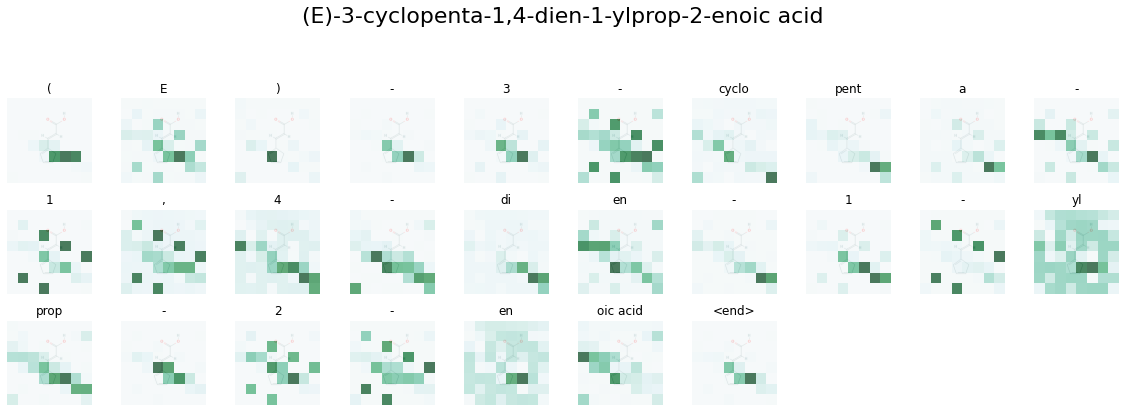

In [106]:
print(sequences_test[6])
pred, attention = evaluate(image_test[6], tokenizer.longest_sentences)
print(''.join(pred))
#plt.imshow(image_test[6])
plot_attention(image_test[6], pred, attention)

Real Caption: ['sulfan', 'hexa', 'fluoro', 'adi', 'hexa', 'formyl', 'decan', 'oic acid', 'nitrosoprop', 'undec', 'acet', 'decan', 'sulfon', 'formyl', 'ic acid', 'oxan', 'decan', 'carboxylate', 'b', 'benzyl', 'carboxamide', 'N', 'one', 'oxan', 'undec', 'one', 'N', 'ic acid']
Prediction Caption: 3-(4-hydroxyphenyl)butanoate


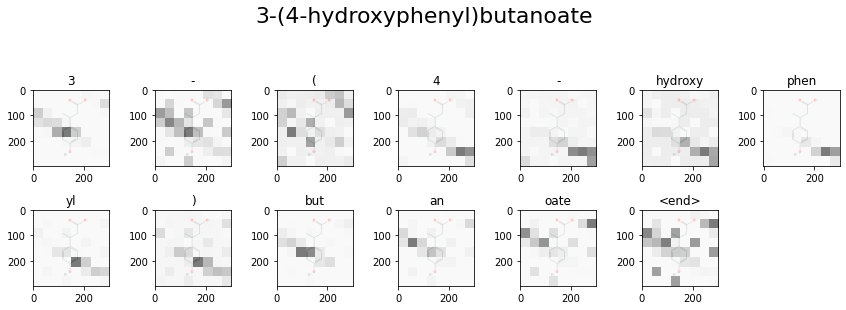

In [51]:
# captions on the validation set
result, attention_plot = evaluate(image_test[33], max_length_test)

print ('Real Caption:', caption_test[33])
print ('Prediction Caption:', ''.join(result[:-1]))

plot_attention(image_test[33], result, attention_plot)

# WER, MER, WIL, WIP

- WER = Word Error Rate
- MER = Match Error Rate
- WIL = Word Information Lost
- WIP = Word Information Preserved

In [2]:
!pip install jiwer

You should consider upgrading via the '/home/namirinz/.virtualenvs/tf/bin/python -m pip install --upgrade pip' command.


In [3]:
import jiwer

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemoveWhiteSpace(replace_by_space=False),
    jiwer.SentencesToListOfWords(word_delimiter=" ")
]) 

In [4]:
ground_truth, _ = kme_segment.word_segmentation(caption_test[118])
hypothesis, _ = evaluate(image_test[118], max_length_test)
score = jiwer.compute_measures(
    ground_truth,
    hypothesis[:-1], 
    truth_transform=transformation, 
    hypothesis_transform=transformation
)

print(ground_truth)
print(hypothesis[:-1])
print(score)

NameError: name 'kme_segment' is not defined

# BLEU SCORE

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## All Bleu Score

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nami.AI.kme_tokenize import Segmentation
from tqdm.notebook import trange
kme_segment = Segmentation()
score1, score2, score3, score4 = [], [], [], []
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_test)):
  word_arr, _ = evaluate(image_test[i], max_length_test)

  real_word,_ = kme_segment.word_segmentation(caption_test[i])

  score1 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(1.0, 0, 0, 0), smoothing_function = chencherry.method4)]))
  score2 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.5, 0.5, 0, 0), smoothing_function = chencherry.method4)]))
  score3 = np.concatenate((score3, [sentence_bleu([real_word], word_arr[:-1], weights=(0.3, 0.3, 0.3, 0), smoothing_function = chencherry.method4)]))
  score4 = np.concatenate((score4, [sentence_bleu([real_word], word_arr[:-1], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function = chencherry.method4)]))

In [ ]:
print(f"BLEU1 {np.mean(score1)*100}\n"
      f"BLEU2 {np.mean(score2)*100}\n"
      f"BLEU3 {np.mean(score3)*100}\n"
      f"BLEU4 {np.mean(score4)*100}\n"
      )

BLEU1 30.104544997795816
BLEU2 29.991428209183695
BLEU3 29.975430691215116
BLEU4 24.43828088270166



In [ ]:
best_score = {}
chencherry = SmoothingFunction()

for i in trange(len(image_train)):
  word_arr, _ = evaluate(image_train[i], max_length_train)
  real_word,_ = kme_segment.word_segmentation(caption_train[i])

  score = sentence_bleu([real_word], word_arr[:-1], smoothing_function = chencherry.method4)
  best_score[i] = score
  #print(f"{i} | {score:.4f}", end=' ')
  #print(''.join(word_arr[:-1]), end=' : ')
  #print(caption_train[i])

In [ ]:
sort_best_score = sorted(best_score.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i in range(30):
  print(sort_best_score[i][0], sort_best_score[i][1])

33 1.0
114 1.0
212 1.0
316 1.0
323 1.0
367 1.0
385 1.0
452 1.0
542 1.0
569 1.0
282 0.9193227152249185
175 0.8931539818068694
540 0.8408964152537145
13 0.8091067115702212
563 0.8091067115702212
336 0.7598356856515925
369 0.7419446627365011
204 0.7259795291154771
287 0.7071067811865475
66 0.7016879391277372
227 0.7016879391277372
292 0.6989307622784944
604 0.6736041912625804
419 0.668740304976422
17 0.6606328636027614
135 0.6606328636027614
378 0.6262844962765469
565 0.6223329772884784
216 0.6186101569833722
163 0.6147881529512643


# Example

Real Caption: ['buta', 'hexa', 'carboxylic acid', 'carboxylate', 'carboxamide', 'undec', 'nitrosoprop', 'undec', 'sulfon', 'decan', 'nitrosoprop', 'one', 'dodec', 'undec', 'carboxylate', 'undec', 'aldehyde', 'en', '6', 'buta', 'hexa', 'one', 'itro', 'sulfon', 'decan', 'nitrosoprop', 'hepta', 'oic acid', 'hepta', 'oxan', 'ic acid', 'hexa', 'bis', 'hexa', 'oxo', 'one', 'nitrosoprop', 'benzyl', 'undec', 'acet', 'decan', 'carboxylate', 'hepta', 'oxo', 'dec', 'one', 'oxo', 'hepta', 'oic acid']
Prediction Caption: 5-fluoropyridin-1-carboxylic acid


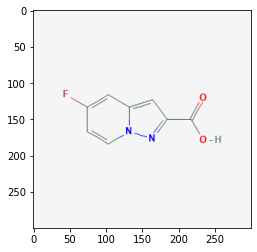

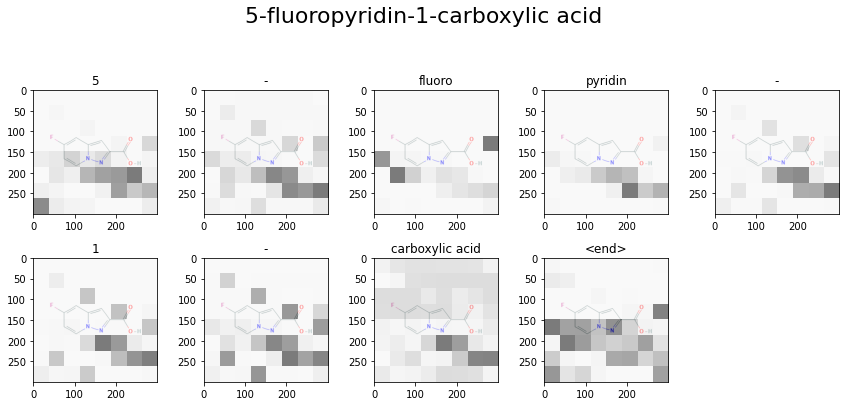

In [53]:
# captions on the validation set
result, attention_plot = evaluate(image_test[2], max_length_train)

print ('Real Caption:', caption_test[2])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[2])
plt.show()
plot_attention(image_test[2], result, attention_plot)


Real Caption: deca-1,6-diyne
Prediction Caption: deca-1,6-diyne


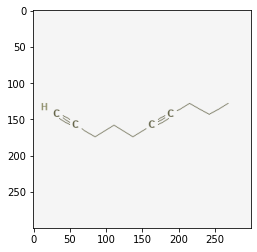

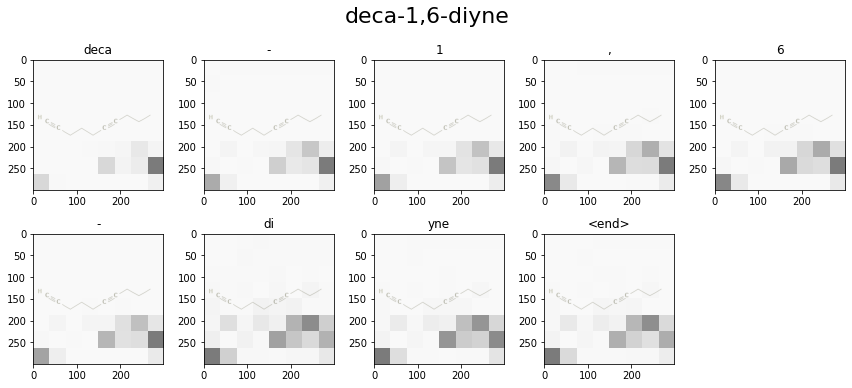

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[52], max_length_test)

print ('Real Caption:', caption_test[52])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[52])
plt.show()
plot_attention(image_test[52], result, attention_plot)


Real Caption: prop-2-en-1-ol
Prediction Caption: prop-2-en-1-ol


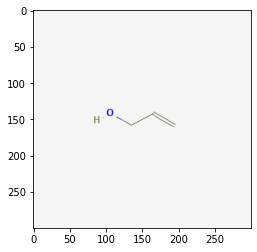

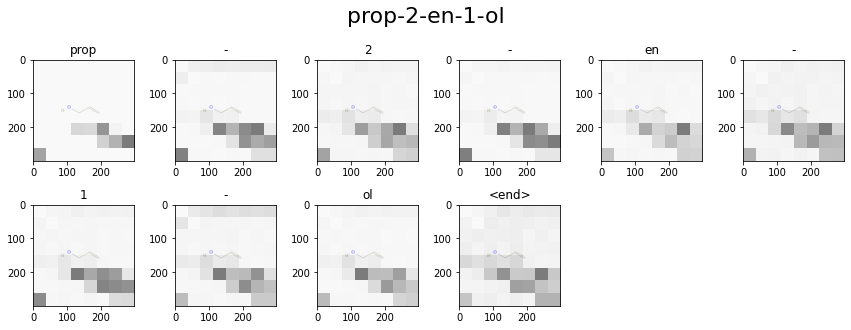

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[243], max_length_train)

print ('Real Caption:', caption_test[243])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[243])
plt.show()
plot_attention(image_test[243], result, attention_plot)


Real Caption: 1,1-bis(methylsulfanyl)ethene
Prediction Caption: 1,3-dimethylpropane


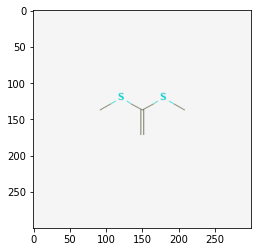

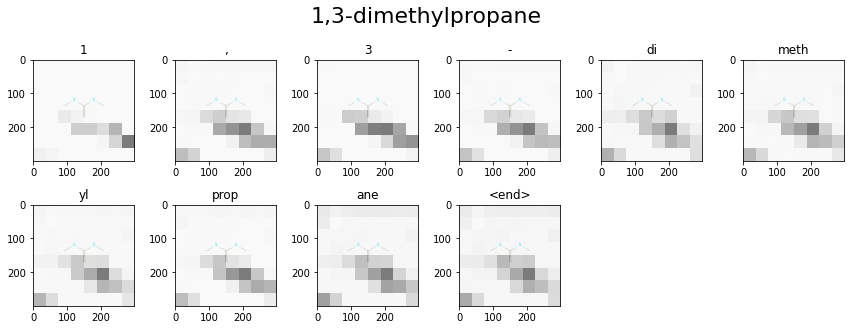

In [ ]:
# captions on the validation set
result, attention_plot = evaluate(image_test[22], max_length_test)

print ('Real Caption:', caption_test[22])
print ('Prediction Caption:', ''.join(result[:-1]))
plt.imshow(image_test[22])
plt.show()
plot_attention(image_test[22], result, attention_plot)
